In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

!pip install --upgrade keras tensorflow
!pip install --upgrade keras kagglehub

import kagglehub
arshid_iris_flower_dataset_path = kagglehub.dataset_download('arshid/iris-flower-dataset')

print('Data source import complete.')


Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.optimizers import Adam


import os
for dirname, _, filenames in os.walk(arshid_iris_flower_dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

iris_csv_path = os.path.join(arshid_iris_flower_dataset_path, "IRIS.csv")

/root/.cache/kagglehub/datasets/arshid/iris-flower-dataset/versions/1/IRIS.csv


# Pré-processamento
---

- **Leitura do arquivo de dados (`IRIS.csv`)**

In [3]:
df = pd.read_csv(iris_csv_path)
df.head() # Primeiras 5 instâncias

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


- **Informações sobre os dados**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


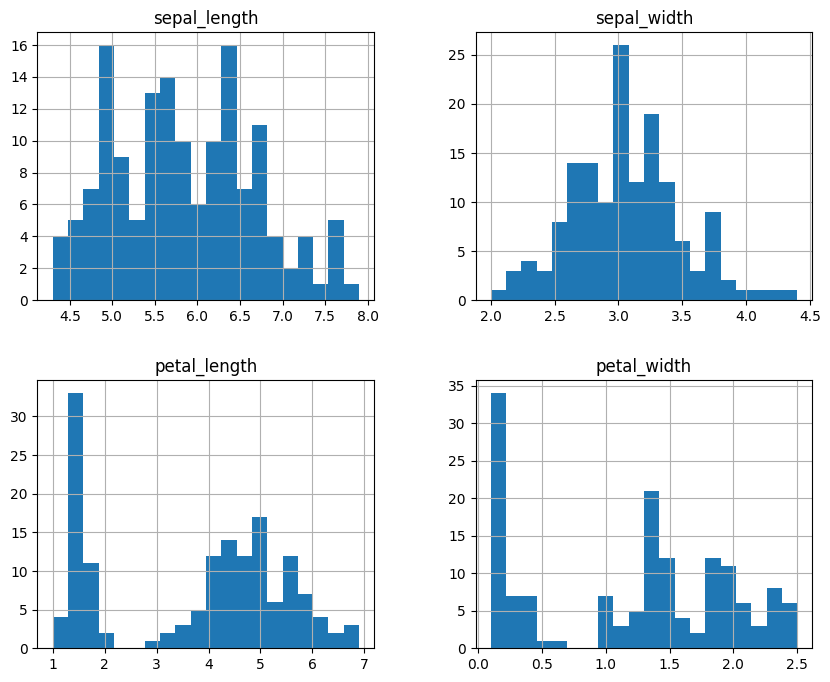

In [5]:
df.hist(column=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], bins=20, figsize=(10, 8))
plt.show()

- **Normalização dos dados**

In [6]:
le = sk.preprocessing.LabelEncoder()
df["species"] = le.fit_transform(df["species"])

In [7]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


- **Dividindo código entre teste e treinamento** (70% será destinado ao treinamento)

In [9]:
X = df.values[:,:-1] # Todas as linhas e colunas (exceto a última)
Y = df.values[:,-1] # Todas as linhas da última coluna
train_set_X, test_set_X, train_set_Y, test_set_Y = train_test_split(X, Y, test_size=0.30, random_state=7)

- **Normalização dos dados usando Min-Max**

  Os valores agora passarão a variar entre zero e um, diminuindo a possibilidade de um atributo dominar o outro dado o seu valor.

In [10]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train_set_X)
X_test_scaled = scaler.transform(test_set_X) # Usa os parâmetros ajustados do conjunto de treino para transformar o conjunto de teste, isso evita viés

In [11]:
n = train_set_X.shape[1]  # número de atributos
m = train_set_X.shape[0]  # número de exemplos de treinamento

print("Número de atributos: n = " + str(n))
print("Número de exemplos de treinamento: m = " + str(m))
print("Formato do conjunto de treino X: " + str(train_set_X.shape))
print("Formato do conjunto de treino Y: " + str(train_set_Y.shape))
print("Formato do conjunto de teste X: " + str(test_set_X.shape))
print("Formato do conjunto de teste Y: " + str(test_set_Y.shape))

Número de atributos: n = 4
Número de exemplos de treinamento: m = 105
Formato do conjunto de treino X: (105, 4)
Formato do conjunto de treino Y: (105,)
Formato do conjunto de teste X: (45, 4)
Formato do conjunto de teste Y: (45,)


# Configuração do modelo
---

- **Definindo a estrutura da rede...**

In [12]:
import keras

inputs = keras.Input(shape=(train_set_X.shape[1],))  # Mesma quantidade dos atributos

layer1 = keras.layers.Dense(units=64, activation='leaky_relu')(inputs)
dropout1 = keras.layers.Dropout(0.2)(layer1)

layer2 = keras.layers.Dense(units=32, activation='leaky_relu')(dropout1)
dropout2 = keras.layers.Dropout(0.2)(layer2)

layer3 = keras.layers.Dense(units=16, activation='leaky_relu')(dropout2)

outputs = keras.layers.Dense(units=3, activation="softmax")(layer3)  # Quantidade de classes diferentes

model = keras.models.Model(inputs=inputs, outputs=outputs)

- **Exibindo a estrutura da rede**

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,979 (11.64 KB)

 Trainable params: 2,979 (11.64 KB)

 Non-trainable params: 0 (0.00 B)

# Compilação do modelo
---

In [14]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', keras.metrics.SparseCategoricalAccuracy()])

# Treinamento do modelo
---

In [15]:
history = model.fit(train_set_X, train_set_Y, batch_size=32, epochs=50)
print(history.history)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3819 - loss: 1.3596 - sparse_categorical_accuracy: 0.3819
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2972 - loss: 1.2428 - sparse_categorical_accuracy: 0.2972 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3233 - loss: 1.1254 - sparse_categorical_accuracy: 0.3233 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3999 - loss: 1.1023 - sparse_categorical_accuracy: 0.3999 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3195 - loss: 1.0614 - sparse_categorical_accuracy: 0.3195  
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4835 - loss: 1.0330 - sparse_categorical_accuracy: 0.4835  
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4950 - loss: 0.9792 - sparse_categorical_accuracy: 0.4950 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6126 - loss: 0.8763 - sparse_categorical_accuracy: 0.6126
Epoch 9/50
4/4 ━━━━━━━━━━━━━

# Avaliação do modelo

In [16]:
loss, acc, sparse_acc= model.evaluate(test_set_X, test_set_Y)

print("Loss: %.2f" % loss, "\nAccuracy: %.2f" % acc, "\nSparse Accuracy: %.2f" % sparse_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9748 - loss: 0.2246 - sparse_categorical_accuracy: 0.9748 
Loss: 0.21 
Accuracy: 0.98 
Sparse Accuracy: 0.98


# Predição

In [17]:
predictions = model.predict(test_set_X)
predicted_classes = [np.argmax(pred) for pred in predictions]  # Pega a classe com a maior probabilidade

correct_labels = [int(x) for x in test_set_Y]

num_correct = sum([1 for i in range(len(correct_labels)) if predicted_classes[i] == correct_labels[i]])

print("Número de acertos:", num_correct)
print("Total de exemplos:", len(correct_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Número de acertos: 44
Total de exemplos: 45
